In [1]:
import findspark
findspark.add_packages("org.mongodb.spark:mongo-spark-connector_2.12:2.4.2")

In [2]:
import os
import pyspark
from dotenv import dotenv_values

# Retrieve MongoDB creds
config = dotenv_values("creds.env")

user = config['user']
password = config['password']

db = "gfw"

# Connect to MongoDB
uri = "mongodb+srv://" + user + ":" + password + "@cluster0.6jfc5iw.mongodb.net/"

# Start Spark session
conf = pyspark.SparkConf() \
.set("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:2.4.2") \
.setMaster("local") \
.setAppName("My app") \
.setAll([("spark.driver.memory", "10g"), ("spark.executor.memory", "12g")])

sc = pyspark.SparkContext(conf=conf)

spark = pyspark.sql.SparkSession(sc)
spark

In [18]:
import random
from pyspark.sql.functions import max, min, explode, col, from_json, when, count, first
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType, DoubleType

In [4]:
# Load 100 US stocks data
# Limiting how much data we are loading to prevent from going over memory usage limit
stocks_pipeline = [
    { "$match": { "Country Code": "USA" } },
    { "$limit": 100 }
]

stocks = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option('uri', uri) \
    .option('database', db) \
    .option('collection', 'stocks') \
    .option('pipeline', stocks_pipeline) \
    .option('allowDiskUse', 'true') \
    .load()

In [5]:
stocks.printSchema()

root
 |-- Common Name: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Stock ID: string (nullable = true)
 |-- Years: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Year: integer (nullable = true)
 |    |    |-- Measures: array (nullable = true)
 |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |-- Measure ID: string (nullable = true)
 |    |    |    |    |-- Measure description: string (nullable = true)
 |    |    |    |    |-- Unit: string (nullable = true)
 |    |    |    |    |-- Value: double (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [6]:
# Load US subsidies data
subsidies_pipeline = [
    { "$match": { "Country Code": "USA" } }
]

subsidies = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option('uri', uri) \
    .option('database', db) \
    .option('collection', 'subsidies') \
    .option('pipeline', subsidies_pipeline) \
    .option('allowDiskUse', 'true') \
    .load()

In [7]:
subsidies.printSchema()

root
 |-- Country: string (nullable = true)
 |-- Country Code: string (nullable = true)
 |-- Total Payments: double (nullable = true)
 |-- Total Support: double (nullable = true)
 |-- Unit Code: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [8]:
# Get date ranges of subsidies data
subsidies.select(min("Year"), max("Year")).show()

+---------+---------+
|min(Year)|max(Year)|
+---------+---------+
|     2010|     2020|
+---------+---------+



In [9]:
# Get date ranges of stocks data
stocks= stocks.select("Stock ID", "Common Name", explode("Years").alias("Years"))
stocks.agg(min("Years.Year"), max("Years.Year")).show()

+---------------+---------------+
|min(Years.Year)|max(Years.Year)|
+---------------+---------------+
|           1990|           2021|
+---------------+---------------+



In [10]:
# Perform analysis on date rage 2010-2020
# Drop any rows from stocks outside of date range
stocks = stocks.filter((col("Years.Year") >= 2010) & (col("Years.Year") <= 2020))

In [11]:
stocks.printSchema()

root
 |-- Stock ID: string (nullable = true)
 |-- Common Name: string (nullable = true)
 |-- Years: struct (nullable = true)
 |    |-- Year: integer (nullable = true)
 |    |-- Measures: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- Measure ID: string (nullable = true)
 |    |    |    |-- Measure description: string (nullable = true)
 |    |    |    |-- Unit: string (nullable = true)
 |    |    |    |-- Value: double (nullable = true)



In [12]:
# Unpack Measures and Years into separate columns
stocks = stocks \
.withColumn("Year", col("Years.Year")) \
.withColumn("Measures", col("Years.Measures")) \
.drop("Years")

In [13]:
stocks.printSchema()

root
 |-- Stock ID: string (nullable = true)
 |-- Common Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Measures: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- Measure ID: string (nullable = true)
 |    |    |-- Measure description: string (nullable = true)
 |    |    |-- Unit: string (nullable = true)
 |    |    |-- Value: double (nullable = true)



In [14]:
# Choose most prevalent measures to analyze
stocks = stocks.select("Stock ID", "Common Name", "Year", explode("Measures").alias("Measure"))

# Unpack stocks
stocks = stocks \
.withColumn("Measure ID", col("Measure.Measure ID")) \
.withColumn("Measure description", col("Measure.Measure description")) \
.withColumn("Unit", col("Measure.Unit")) \
.withColumn("Value", col("Measure.Value")) \
.drop("Measure")

# Deduplicate measure IDs
stocks = stocks.dropDuplicates(["Stock ID", "Common Name", "Year", "Measure ID"])

stocks.groupBy("Measure ID").count().orderBy("count", ascending=False).show(truncate=False)

+-------------------------------+-----+
|Measure ID                     |count|
+-------------------------------+-----+
|CdivMEANC-ratio                |455  |
|TCbest-MT                      |454  |
|TC-MT                          |450  |
|BdivBmsytouse-dimensionless    |390  |
|BdivBmgtpref-dimensionless     |390  |
|BdivBmsypref-dimensionless     |390  |
|UdivUmsypref-dimensionless     |372  |
|UdivUmgtpref-dimensionless     |372  |
|UdivUmsytouse-dimensionless    |369  |
|SSBdivSSBmsy-calc-dimensionless|364  |
|R-E00                          |358  |
|F-1/yr                         |343  |
|FdivFmsy-calc-dimensionless    |334  |
|SSB-MT                         |284  |
|CdivMSY-ratio                  |275  |
|TB-MT                          |207  |
|TBbest-MT                      |207  |
|ERbest-ratio                   |202  |
|ER-calc-ratio                  |165  |
|SSB-E00eggs                    |103  |
+-------------------------------+-----+
only showing top 20 rows



In [15]:
# Only perform analysis on the top 5 measures: CdivMEANC-ratio, TCbest-MT, TC-MT
measures_keep = ['CdivMEANC-ratio', 'TCbest-MT', 'TC-MT', 'BdivBmsytouse-dimensionless', 'BdivBmsypref-dimensionless']

stocks = stocks.filter(col("Measure ID").isin(measures_keep))

In [16]:
# Separate dataframe by measure IDS
df_measures = []

for measure in measures_keep:
    df = stocks.filter(col("Measure ID") == measure)
    df_measures.append(df)

In [35]:
stock_ID = random.choice(list(stocks.select("Stock ID").distinct().toPandas()["Stock ID"]))

In [36]:
print(stock_ID)

BLACKROCKORECOAST


In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
subsidies_data = subsidies.select("Year", "Total Support", "Total Payments").orderBy("Year").toPandas()

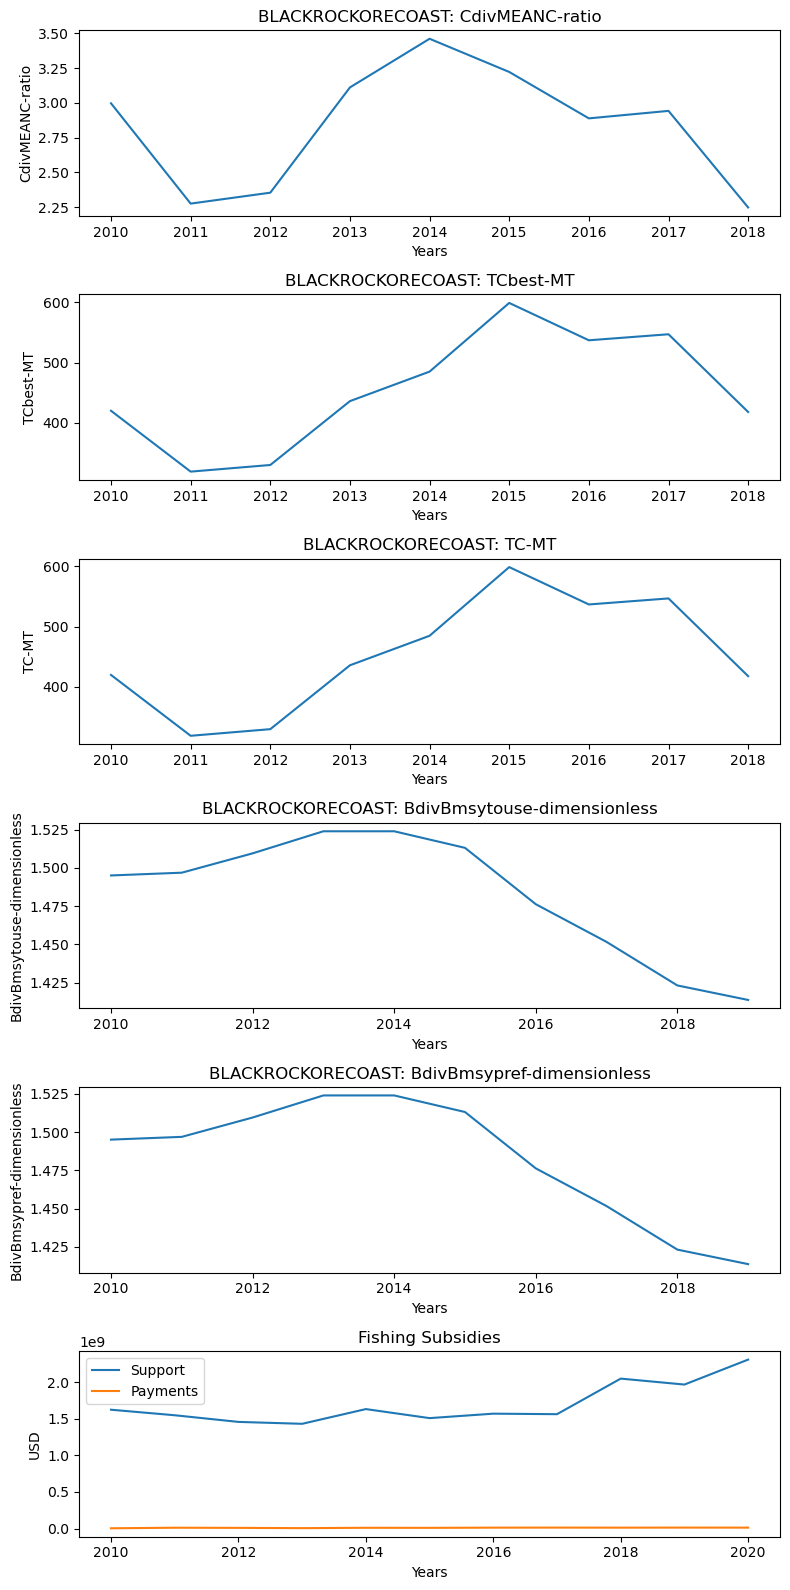

In [42]:
fig, axs = plt.subplots(6, figsize=(8, 16))

for i, df in enumerate(df_measures):
    data = df.filter(col("Stock ID") == stock_ID).select("Value", "Year").orderBy("Year").toPandas()
    
    axs[i].plot(data["Year"], data["Value"], label=stock_ID)
        
    axs[i].set_title(f'{stock_ID}: {measures_keep[i]}')
    axs[i].set_ylabel(measures_keep[i])
    axs[i].set_xlabel("Years")
    
axs[5].plot(subsidies_data["Year"], subsidies_data["Total Support"], label="Support")
axs[5].plot(subsidies_data["Year"], subsidies_data["Total Payments"], label="Payments")
axs[5].set_xlabel("Years")
axs[5].set_ylabel("USD")
axs[5].set_title("Fishing Subsidies")
axs[5].legend(loc='upper left')

plt.tight_layout()
plt.show()